In [1]:
import logging
import sys
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))

from lib.reactor_settings import ReactorSettings
from lib.storage_tank import StorageTank
from lib.power_system import PowerSystem
from lib.atmosphere_intake_system import AtmosphereIntakeSystem
from lib.containment_vessel import ContainmentVessel
from lib.sabatier_reactor import SabatierReactor
from lib.electrolysis_reactor import ElectrolysisReactor

# Set up logging
logging.basicConfig(
    filename='simulation.log',
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set up Seaborn for better visuals
sns.set_theme(style="whitegrid")

In [5]:
# Initialize simulation components

# Storage tanks for reactants and products
settings = ReactorSettings()
CO2_tank = StorageTank("CO2", capacity=10000)
H2_tank = StorageTank("H2", capacity=5000, level=400)
CH4_tank = StorageTank("CH4", capacity=3000)
H2O_tank = StorageTank("H2O", capacity=2000)
O2_tank = StorageTank("O2", capacity=5000)

# Environmental cycles
# Define Mars-specific constants
martian_day_hours = 24.6  # Length of a Martian day in Earth hours
martian_year_days = 687   # Length of a Martian year in Earth days
time_steps_per_day = int(martian_day_hours)  # Simulation time steps per day (1-hour intervals)
time_steps_per_year = martian_year_days * time_steps_per_day  # Total steps for one Martian year

# Simulation duration (e.g., 3 Martian years)
num_years = 0.1
total_time_steps = int(time_steps_per_year * num_years)

# Seasonal Temperature Variation: amplitude over Martian year with a baseline Martian avg temp ~ -60°C
seasonal_temp_variation_c = 30  # Temperature seasonal swing in degrees Celsius
daily_temp_fluctuation_c = 40   # Daily swing in degrees Celsius

# Temperature Cycle
seasonal_component_c = (np.sin(np.linspace(0, 2 * np.pi * num_years, total_time_steps)) * seasonal_temp_variation_c)
daily_component_c = (np.sin(np.linspace(0, 2 * np.pi * total_time_steps / martian_day_hours, total_time_steps)) * daily_temp_fluctuation_c)
temperature_cycle_c = -60 + seasonal_component_c + daily_component_c + np.random.normal(0, 2, total_time_steps)  # Added noise

# Pressure Cycle: Mars surface pressure varies between ~600 Pa to ~1200 Pa across seasons
seasonal_pressure_variation_pa = 300  # Seasonal pressure swing in Pa
daily_pressure_fluctuation_pa = 50    # Daily pressure swing in Pa

# Pressure Cycle
seasonal_component_pressure_pa = (np.cos(np.linspace(0, 2 * np.pi * num_years, total_time_steps)) * seasonal_pressure_variation_pa)
daily_component_pressure_pa = (np.cos(np.linspace(0, 2 * np.pi * total_time_steps / martian_day_hours, total_time_steps)) * daily_pressure_fluctuation_pa)
pressure_cycle_pa = 800 + seasonal_component_pressure_pa + daily_component_pressure_pa + np.random.normal(0, 10, total_time_steps)  # Added noise


# Initialize reactor and intake systems
power_system = PowerSystem(
    solar_max_kw=10,
    nuclear_max_kw=20,
    battery_capacity_kj=500,
    battery_level_kj=250 # Start with half capacity
)

atmosphere_intake = AtmosphereIntakeSystem(
    name="Martian Atmosphere Intake",
    CO2_tank=CO2_tank,
    power_system=power_system,
    intake_rate=100,      # Example intake rate: 100g of CO2 per cycle
    power_per_cycle=50,   # Example power requirement: 50 kJ per cycle
    interval_hours=12
)

sabatier_reactor_containment_vessel = ContainmentVessel(
    target_temp_c=275,              # Optimal temperature for the Sabatier reaction in Celsius
    vessel_volume_m3=1,             # Volume of the Sabatier reactor containment vessel in cubic meters
    target_pressure_pa=100000,      # Optimal pressure for Sabatier reaction, ~1 bar or 100,000 Pa
    insulation_factor=0.8,          # Insulation efficiency to reduce heat loss
    heating_power_kw=10,            # Heating system power in kW
    pressurization_power_kw=5,      # Pressurization system power in kW (adjust based on power requirements)
    internal_temp_c=-60,            # Initial internal temperature, Mars average
    internal_pressure_pa=600,       # Initial internal pressure, starting at Mars ambient (~600 Pa)
    power_system=power_system       # Reference to the power system to track energy usage
)

sabatier_reactor = SabatierReactor(
    settings=settings, 
    efficiency=0.9,
    catalyst_degradation_rate=0.0001,
    vessel=sabatier_reactor_containment_vessel,
    temperature_cycle_c=temperature_cycle_c,
    pressure_cycle_pa=pressure_cycle_pa,
    CO2_tank=CO2_tank,
    H2_tank=H2_tank,
    CH4_tank=CH4_tank,
    H2O_tank=H2O_tank,
    power_system=power_system
)

electrolysis_reactor = ElectrolysisReactor(settings, H2O_tank, H2_tank, O2_tank, power_system)

In [6]:
# Initialize a dictionary to store simulation data by time step
simulation_data = {
    "CO2_level": [],
    "H2_level": [],
    "CH4_level": [],
    "H2O_level": [],
    "O2_level": [],
    "battery_level": [],
    "power_demand": [],
    "H2_produced": [],
    "O2_produced": [],
    "CO2_added": [],
    "intake_power_demand": [],
    "electrolysis_power_demand": [],
    "sabatier_power_demand": [],
    "internal_temp_c": [],
    "internal_pressure_pa": [],
    "catalyst_efficiency": [],
    "solar_power_generated": [],
    "nuclear_power_generated": [],
    "hour": []
}


for hour in range(total_time_steps):
    logger.info(f"Running simulation for hour {hour}")

    total_power_generated = power_system.available_power(hour)

    # Run atmosphere intake system cycle
    intake_result = atmosphere_intake.run_cycle(hour, total_power_generated)

    # Run Sabatier reactor cycle
    sabatier_result, battery_level = sabatier_reactor.run_cycle(hour, total_power_generated)

    # Run electrolysis reactor cycle
    electrolysis_result = electrolysis_reactor.run_cycle(hour, total_power_generated)
    
    # Collect data for this time step
    simulation_data["CO2_level"].append(CO2_tank.level)
    simulation_data["H2_level"].append(H2_tank.level)
    simulation_data["CH4_level"].append(CH4_tank.level)
    simulation_data["H2O_level"].append(H2O_tank.level)
    simulation_data["O2_level"].append(O2_tank.level)

    simulation_data["sabatier_power_demand"].append(
        sabatier_result.get("Heating Power Used (kJ)", 0) +
        sabatier_result.get("Pressurization Power Used (kJ)", 0)
    )
    simulation_data["battery_level"].append(battery_level)
    simulation_data["power_demand"].append(
        simulation_data["sabatier_power_demand"][-1] +
        electrolysis_result["Power Used (kJ)"] +
        intake_result["Power Used (kJ)"]
    )
    
    simulation_data["H2_produced"].append(electrolysis_result["H2 Produced (g)"])
    simulation_data["O2_produced"].append(O2_tank.level)
    simulation_data["CO2_added"].append(intake_result["CO2 Added (g)"])

    simulation_data["intake_power_demand"].append(intake_result["Power Used (kJ)"])
    simulation_data["electrolysis_power_demand"].append(electrolysis_result["Power Used (kJ)"])
    
    simulation_data["internal_temp_c"].append(sabatier_reactor.vessel.internal_temp_c)
    simulation_data["internal_pressure_pa"].append(sabatier_reactor.vessel.internal_pressure_pa)
    simulation_data["catalyst_efficiency"].append(sabatier_reactor.efficiency * (1 - sabatier_reactor.catalyst_degradation_rate * hour))
    
    solar_power_kj = power_system.solar_max_kw * power_system.solar_efficiency * 3600
    nuclear_power_kj = power_system.nuclear_max_kw * 3600
    total_power_available = power_system.available_power(hour)

    simulation_data["solar_power_generated"].append(power_system.last_solar_power_kj)
    simulation_data["nuclear_power_generated"].append(power_system.last_nuclear_power_kj)
    simulation_data["hour"].append(hour)

simulation_df = pd.DataFrame(simulation_data)
simulation_df["sol"] = simulation_df["hour"] / time_steps_per_day

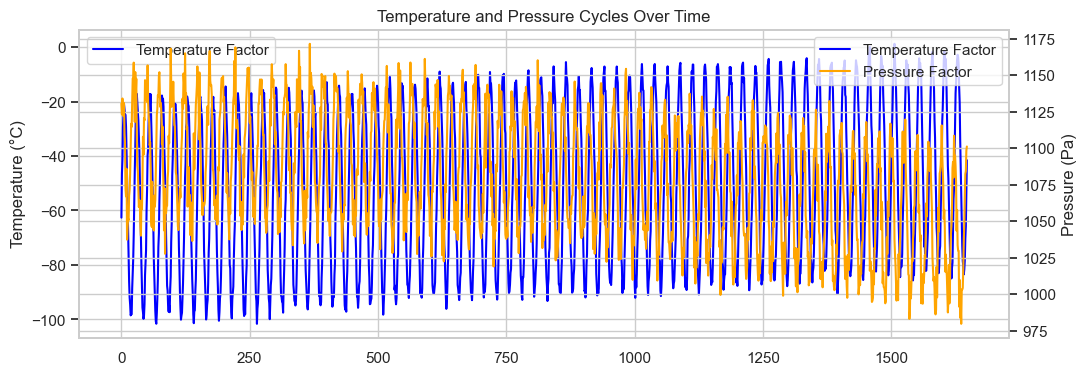

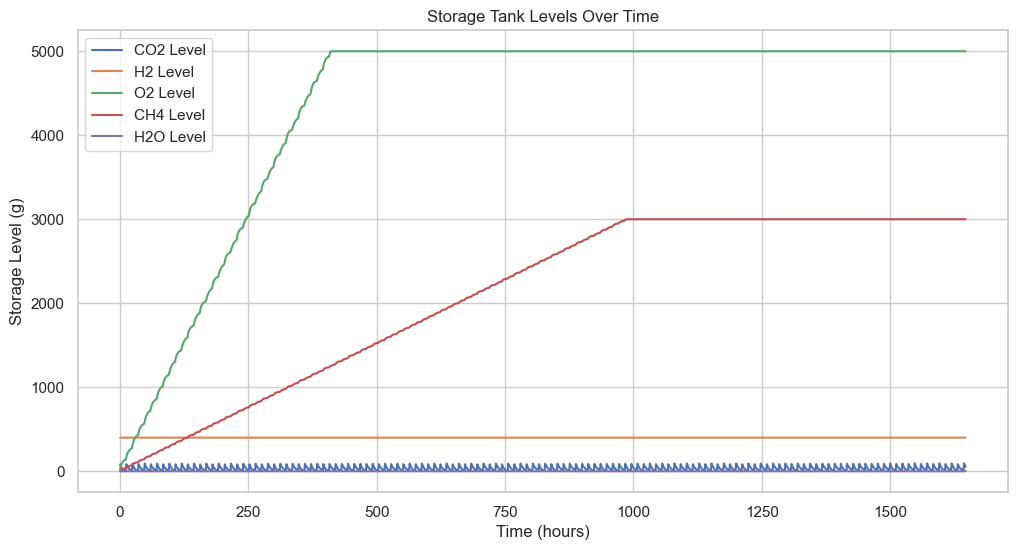

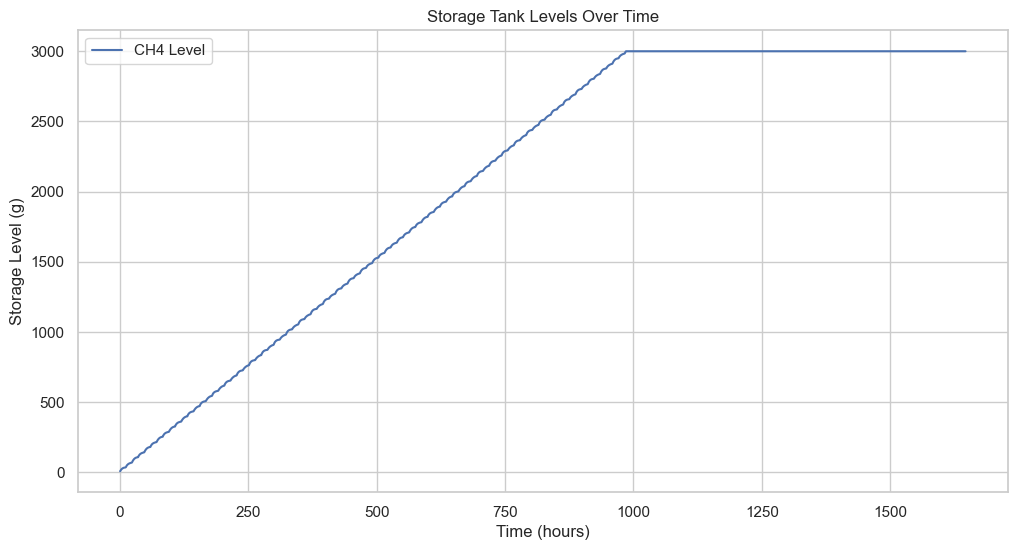

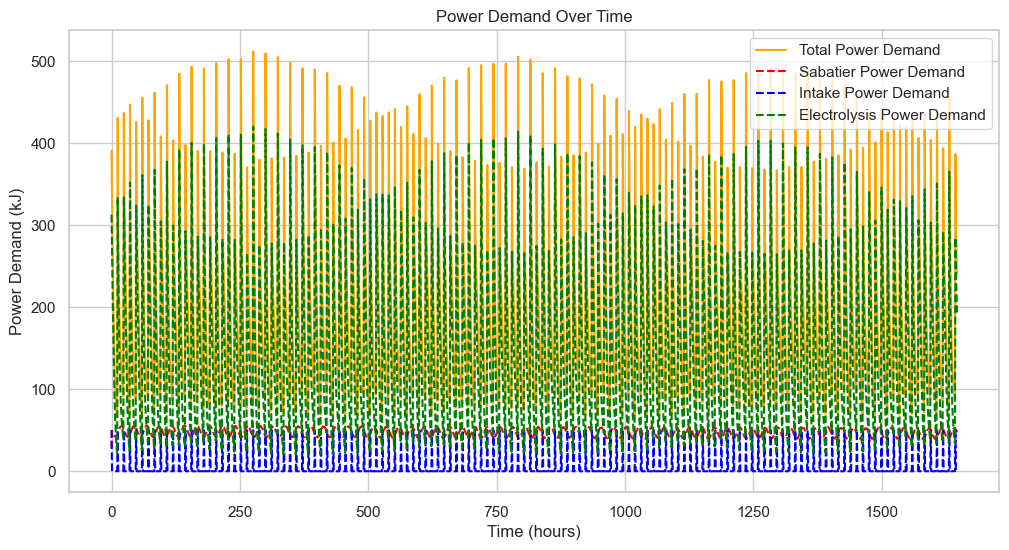

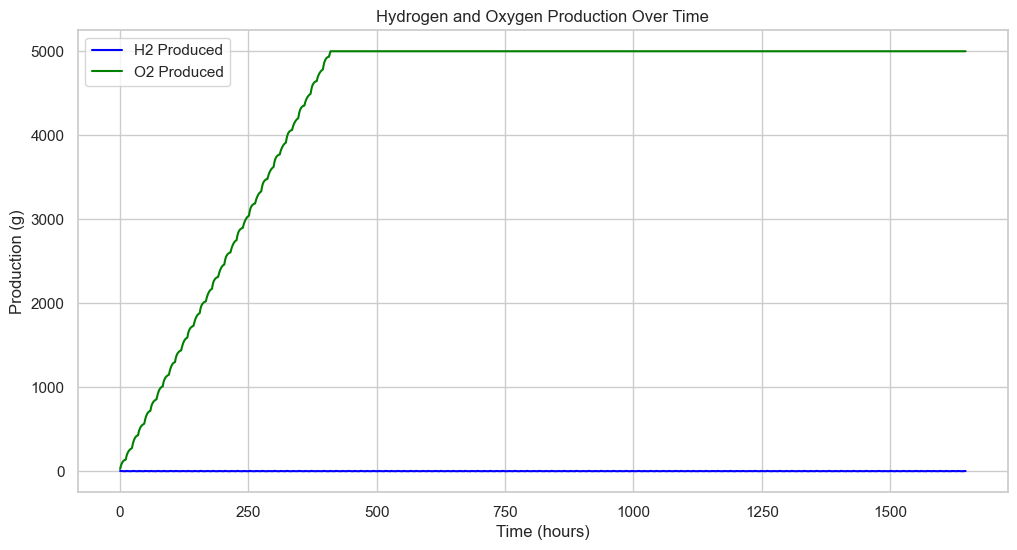

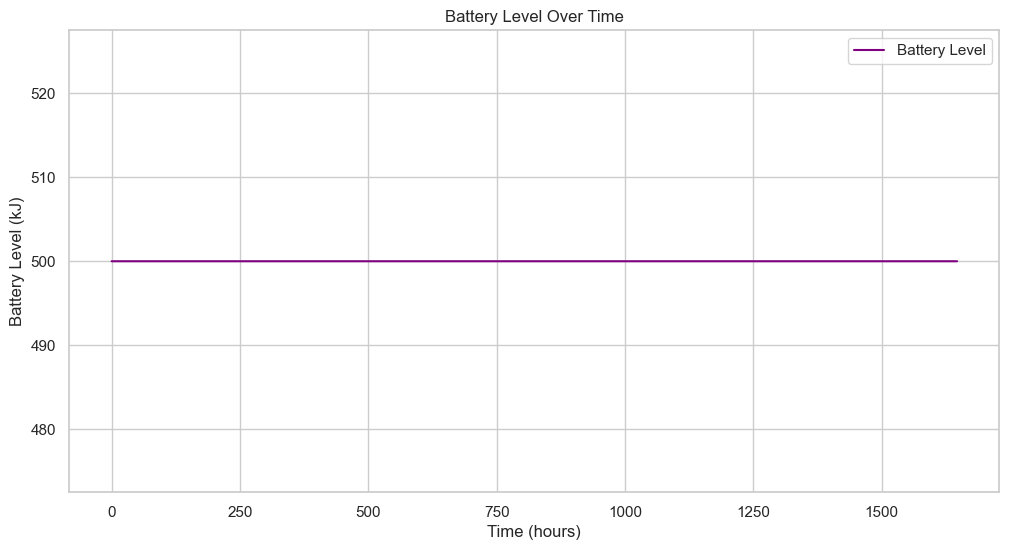

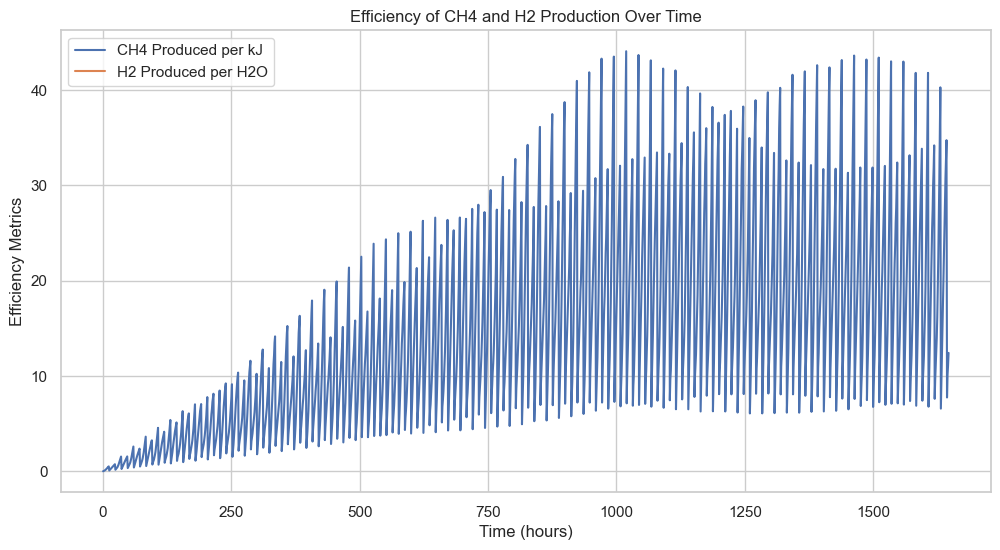

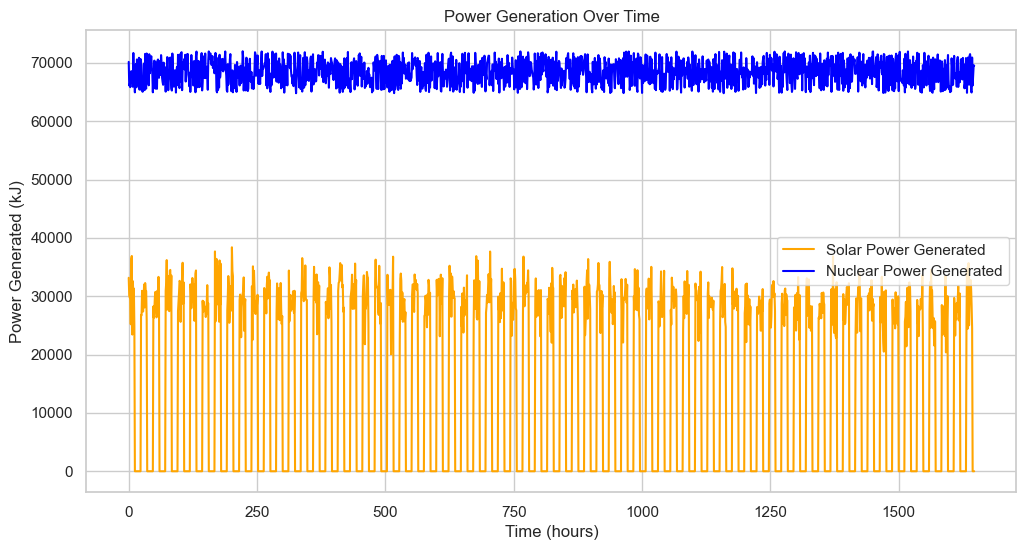

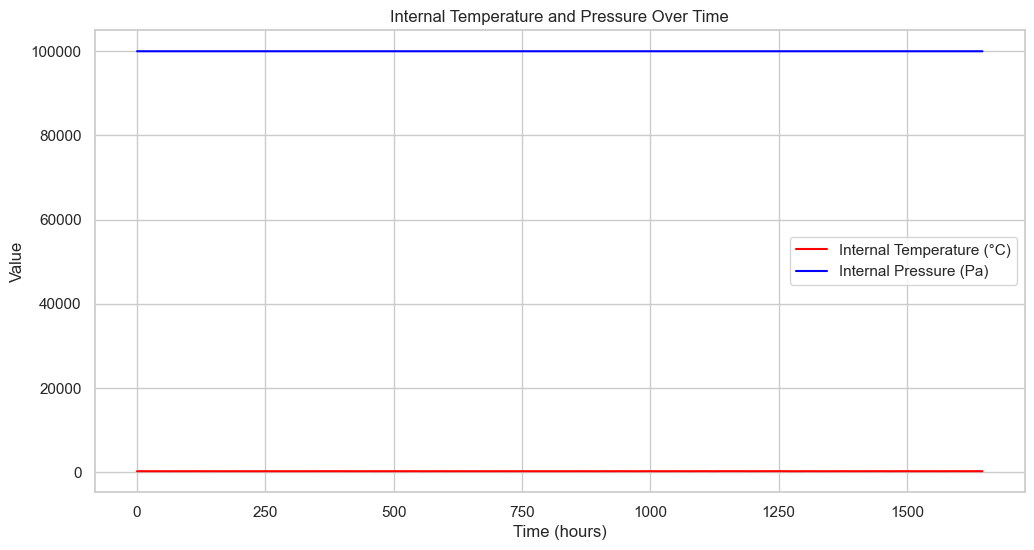

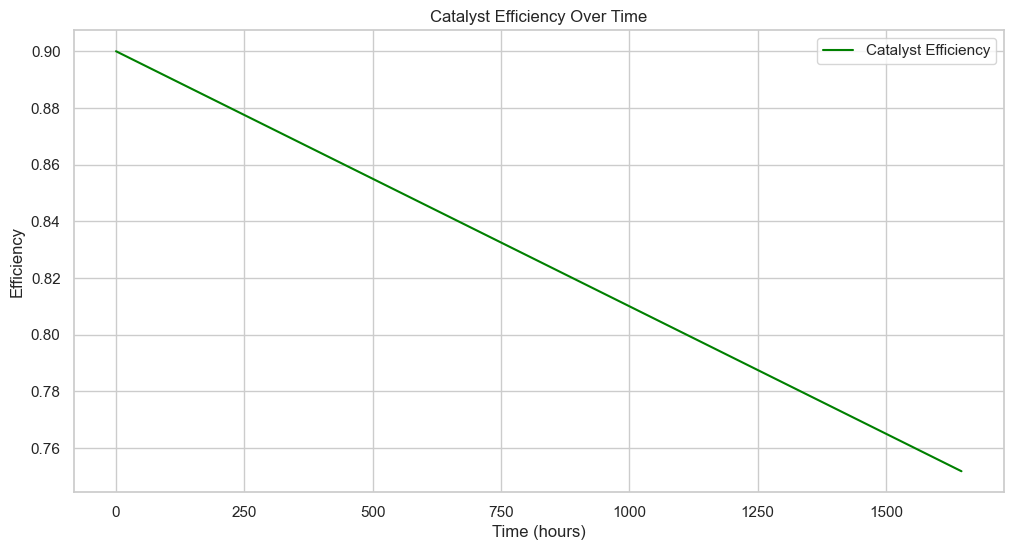

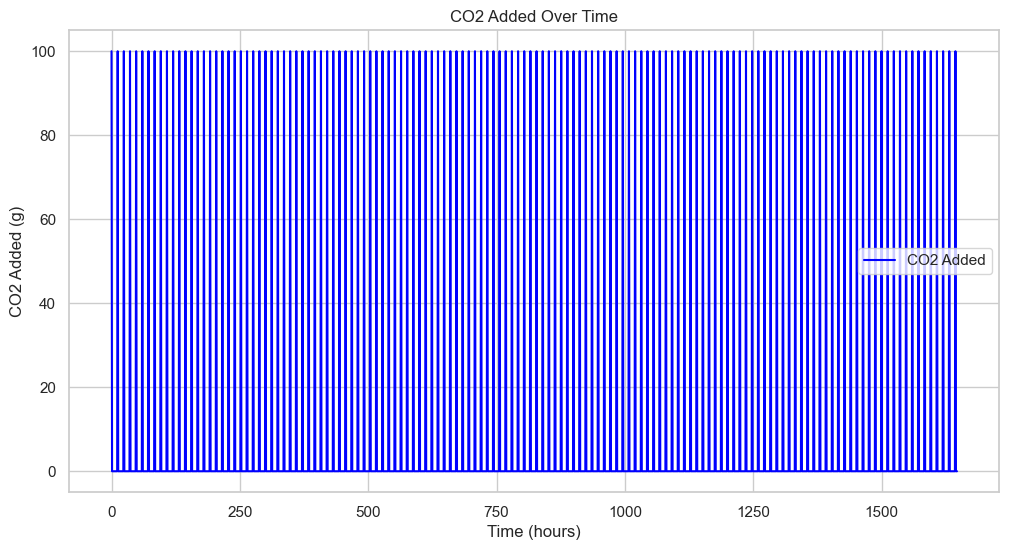

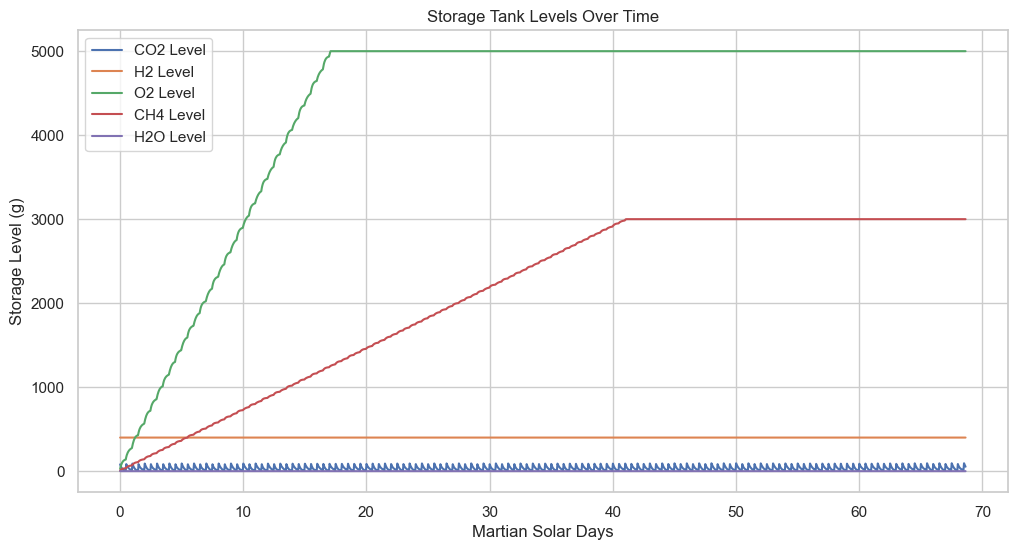

In [7]:


# Plotting the simulation results
plt.figure(figsize=(12, 4))
ax = plt.gca()
sns.lineplot(temperature_cycle_c, label='Temperature Factor', ax = ax, color='blue')
ax.set_ylabel("Temperature (°C)")
ax2 = plt.twinx()
sns.lineplot(pressure_cycle_pa, label='Pressure Factor', ax = ax2, color='orange')
ax2.set_ylabel("Pressure (Pa)")
plt.xlabel("Time (hours)")
plt.title("Temperature and Pressure Cycles Over Time")
# combine the legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["CO2_level"], label='CO2 Level')
plt.plot(simulation_df["H2_level"], label='H2 Level')
plt.plot(simulation_df["O2_level"], label='O2 Level')
plt.plot(simulation_df["CH4_level"], label='CH4 Level')
plt.plot(simulation_df["H2O_level"], label='H2O Level')
plt.xlabel("Time (hours)")
plt.ylabel("Storage Level (g)")
plt.title("Storage Tank Levels Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["CH4_level"], label='CH4 Level')
plt.xlabel("Time (hours)")
plt.ylabel("Storage Level (g)")
plt.title("Storage Tank Levels Over Time")
plt.legend()
plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(simulation_df["H2O_level"], label='H2O Level')
# plt.xlabel("Time (hours)")
# plt.ylabel("Storage Level (g)")
# plt.title("Storage Tank Levels Over Time")
# plt.legend()
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(simulation_df["CO2_level"], label='CO2 Level')
# plt.plot(simulation_df["H2_level"], label='H2 Level')
# plt.plot(simulation_df["O2_level"], label='O2 Level')
# plt.xlabel("Time (hours)")
# plt.ylabel("Storage Level (g)")
# plt.title("Storage Tank Levels Over Time")
# plt.legend()
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(simulation_df["CH4_level"], label='CH4 Level')
# plt.xlabel("Time (hours)")
# plt.ylabel("Storage Level (g)")
# plt.title("Storage Tank Levels Over Time")
# plt.legend()
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(simulation_df["H2O_level"], label='H2O Level')
# plt.xlabel("Time (hours)")
# plt.ylabel("Storage Level (g)")
# plt.title("Storage Tank Levels Over Time")
# plt.legend()
# plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["power_demand"], label='Total Power Demand', color='orange')
plt.plot(simulation_df["sabatier_power_demand"], label='Sabatier Power Demand', color='red', linestyle='dashed')
plt.plot(simulation_df["intake_power_demand"], label='Intake Power Demand', color='blue', linestyle='dashed')
plt.plot(simulation_df["electrolysis_power_demand"], label='Electrolysis Power Demand', color='green', linestyle='dashed')
plt.xlabel("Time (hours)")
plt.ylabel("Power Demand (kJ)")
plt.title("Power Demand Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["H2_produced"], label='H2 Produced', color='blue')
plt.plot(simulation_df["O2_produced"], label='O2 Produced', color='green')
plt.xlabel("Time (hours)")
plt.ylabel("Production (g)")
plt.title("Hydrogen and Oxygen Production Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["battery_level"], label='Battery Level', color='purple')
plt.xlabel("Time (hours)")
plt.ylabel("Battery Level (kJ)")
plt.title("Battery Level Over Time")
plt.legend()
plt.show()

simulation_df['CH4_per_kJ'] = simulation_df['CH4_level'] / simulation_df['power_demand']
simulation_df['H2_per_H2O'] = simulation_df['H2_produced'] / simulation_df['H2O_level']
plt.figure(figsize=(12, 6))
sns.lineplot(data=simulation_df, x=simulation_df.index, y="CH4_per_kJ", label="CH4 Produced per kJ")
sns.lineplot(data=simulation_df, x=simulation_df.index, y="H2_per_H2O", label="H2 Produced per H2O")
plt.xlabel("Time (hours)")
plt.ylabel("Efficiency Metrics")
plt.title("Efficiency of CH4 and H2 Production Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["solar_power_generated"], label='Solar Power Generated', color='orange')
plt.plot(simulation_df["nuclear_power_generated"], label='Nuclear Power Generated', color='blue')
plt.xlabel("Time (hours)")
plt.ylabel("Power Generated (kJ)")
plt.title("Power Generation Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["internal_temp_c"], label='Internal Temperature (°C)', color='red')
plt.plot(simulation_df["internal_pressure_pa"], label='Internal Pressure (Pa)', color='blue')
plt.xlabel("Time (hours)")
plt.ylabel("Value")
plt.title("Internal Temperature and Pressure Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["catalyst_efficiency"], label='Catalyst Efficiency', color='green')
plt.xlabel("Time (hours)")
plt.ylabel("Efficiency")
plt.title("Catalyst Efficiency Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["CO2_added"], label='CO2 Added', color='blue')
plt.xlabel("Time (hours)")
plt.ylabel("CO2 Added (g)")
plt.title("CO2 Added Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["sol"], simulation_df["CO2_level"], label='CO2 Level')
plt.plot(simulation_df["sol"], simulation_df["H2_level"], label='H2 Level')
plt.plot(simulation_df["sol"], simulation_df["O2_level"], label='O2 Level')
plt.plot(simulation_df["sol"], simulation_df["CH4_level"], label='CH4 Level')
plt.plot(simulation_df["sol"], simulation_df["H2O_level"], label='H2O Level')
plt.xlabel("Martian Solar Days")
plt.ylabel("Storage Level (g)")
plt.title("Storage Tank Levels Over Time")
plt.legend()
plt.show()